In [1]:
pip install transformers datasets evaluate seqeval accelerate -U huggingface_hub > /dev/null

In [ ]:
!huggingface-cli login

In [3]:
from datasets import load_dataset
from transformers import AutoTokenizer
import torch
from transformers import DataCollatorForTokenClassification
import evaluate
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Load the data

In [4]:
# Load the data from Huggingface Hub
data = load_dataset("dennishauser/docred_ner", token=True)

data['train'][1]

{'id': '1',
 'tokens': ['It',
  'is',
  'part',
  'of',
  'the',
  'Skai',
  'Group',
  ',',
  'one',
  'of',
  'the',
  'largest',
  'media',
  'groups',
  'in',
  'the',
  'country',
  '.'],
 'ner_tags': [0, 0, 0, 0, 0, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

# Tokenize

In [5]:
# Load the tokenizer from the pretrained model
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [6]:
# Tokenize one example
example = data["train"][0]
tokenized_input = tokenizer(example["tokens"], is_split_into_words=True)
tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
tokens

['[CLS]',
 'ska',
 '##i',
 'tv',
 'is',
 'a',
 'greek',
 'free',
 '-',
 'to',
 '-',
 'air',
 'television',
 'network',
 'based',
 'in',
 'pi',
 '##rae',
 '##us',
 '.',
 '[SEP]']

When tokenizing the data, special tokens [CLS] and and [SEP] are added. Also subword tokenization splits some words into multiple token.
This will create mismatches between the original labels and tokens. Therefore we need to allign the labels after tokenization. The corresponding label will only be at the index of the first occurence of a subword. Special Tokens will be set to -100

In [7]:
def tokenize_and_align_labels(examples):
    # Tokenizing step
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples[f"ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective word.
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:  # Set the special tokens to -100.
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:  # Only label the first token of a given word.
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [8]:
tokenized_data = data.map(tokenize_and_align_labels, batched=True)

In [9]:
# Create a batch of examples with dynamic padding, as this is more efficient, than padding to the maximum lenght
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [10]:
seqeval = evaluate.load("seqeval")

In [11]:
label_list = data["train"].features[f"ner_tags"].feature.names
label_list

['O',
 'B-LOC',
 'I-LOC',
 'B-ORG',
 'I-ORG',
 'B-PER',
 'I-PER',
 'B-NUM',
 'I-NUM',
 'B-TIME',
 'I-TIME',
 'B-MISC',
 'I-MISC']

In [12]:
labels = [label_list[i] for i in example[f"ner_tags"]]


def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [13]:
id2label = {0: 'O',
 1: 'B-LOC',
 2: 'I-LOC',
 3: 'B-ORG',
 4: 'I-ORG',
 5: 'B-PER',
 6: 'I-PER',
 7: 'B-NUM',
 8: 'I-NUM',
 9: 'B-TIME',
 10: 'I-TIME',
 11: 'B-MISC',
 12: 'I-MISC'}

label2id = {'O': 0,
 'B-LOC': 1,
 'I-LOC': 2,
 'B-ORG': 3,
 'I-ORG': 4,
 'B-PER': 5,
 'I-PER': 6,
 'B-NUM': 7,
 'I-NUM': 8,
 'B-TIME': 9,
 'I-TIME': 10,
 'B-MISC': 11,
 'I-MISC': 12}

# Finetuning

In [14]:
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer

model = AutoModelForTokenClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=13, id2label=id2label, label2id=label2id
)

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
training_args = TrainingArguments(
    output_dir="distil-bert-docred-ner",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

Let's get predictions for our base-model before finetuning.

In [16]:
def get_predictions(data):
  predictions, labels, _ = trainer.predict(data)
  predictions = np.argmax(predictions, axis=2)

  # Remove ignored index (special tokens)
  true_predictions = [
      [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
      for prediction, label in zip(predictions, labels)
  ]
  true_labels = [
      [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
      for prediction, label in zip(predictions, labels)
  ]

  return true_predictions, true_labels

In [17]:
prediction_base, labels_base = get_predictions(tokenized_data["test"])

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [18]:
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.132500,0.092262,0.867466,0.890277,0.878723,0.971241
2,0.095200,0.074396,0.892061,0.908077,0.899998,0.976787


TrainOutput(global_step=3032, training_loss=0.15093492274234038, metrics={'train_runtime': 357.492, 'train_samples_per_second': 135.701, 'train_steps_per_second': 8.481, 'total_flos': 750363395992800.0, 'train_loss': 0.15093492274234038, 'epoch': 2.0})

# Inference

Now we can get the predictions and true labels in order to evaluate the results our model is producing.

In [19]:
prediction_finetuned, labels_finetuned = get_predictions(tokenized_data["test"])

Get the evaluation results for all classes.

In [20]:
results = seqeval.compute(predictions=prediction_finetuned, references=labels_finetuned)
results

{'LOC': {'precision': 0.9130488103998038,
  'recall': 0.9298114150118646,
  'f1': 0.921353876616546,
  'number': 8007},
 'MISC': {'precision': 0.7768447837150128,
  'recall': 0.792163985469642,
  'f1': 0.7844295991778005,
  'number': 3854},
 'NUM': {'precision': 0.8916109873793615,
  'recall': 0.9238461538461539,
  'f1': 0.9074423876086135,
  'number': 1300},
 'ORG': {'precision': 0.830949948927477,
  'recall': 0.8538441353975335,
  'f1': 0.8422414908761485,
  'number': 3811},
 'PER': {'precision': 0.9600591715976331,
  'recall': 0.9647483542153323,
  'f1': 0.9623980510539136,
  'number': 4709},
 'TIME': {'precision': 0.9401539607648374,
  'recall': 0.9558192375662712,
  'f1': 0.9479218828242363,
  'number': 3961},
 'overall_precision': 0.8918256339538804,
 'overall_recall': 0.9079634973870992,
 'overall_f1': 0.899822215351318,
 'overall_accuracy': 0.9767463100052262}

## Confusion matrices for the base-model and finetuned model

In [21]:
def plot_confusion_matrix(y_preds, y_true, labels, title):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False, xticks_rotation=85)
    plt.title(title)
    plt.show()

In [22]:
def convert_for_conf(predictions, labels):
  preds = [label2id[item] for sublist in predictions for item in sublist]
  labels = [label2id[item] for sublist in labels for item in sublist]

  return np.array(preds, dtype=np.int64), np.array(labels, dtype=np.int64)

In [23]:
prediction_base, labels_base = convert_for_conf(prediction_base, labels_base)
prediction_finetuned, labels_finetuned = convert_for_conf(prediction_finetuned, labels_finetuned)

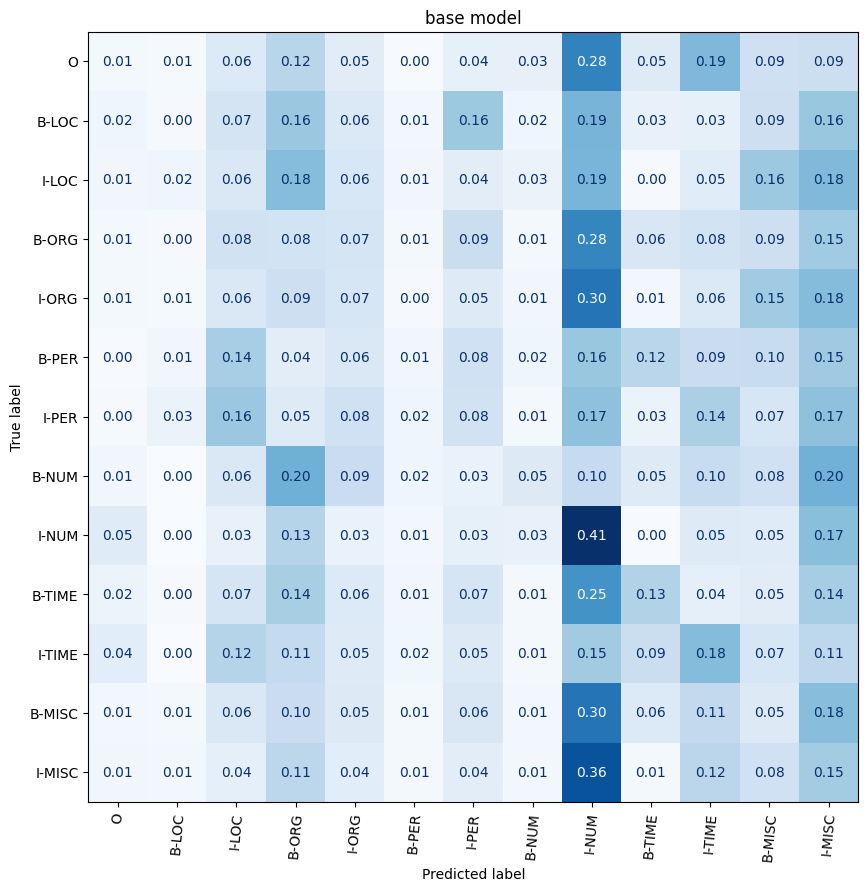

In [24]:
plot_confusion_matrix(prediction_base, labels_base, list(label2id.keys()), "base model")

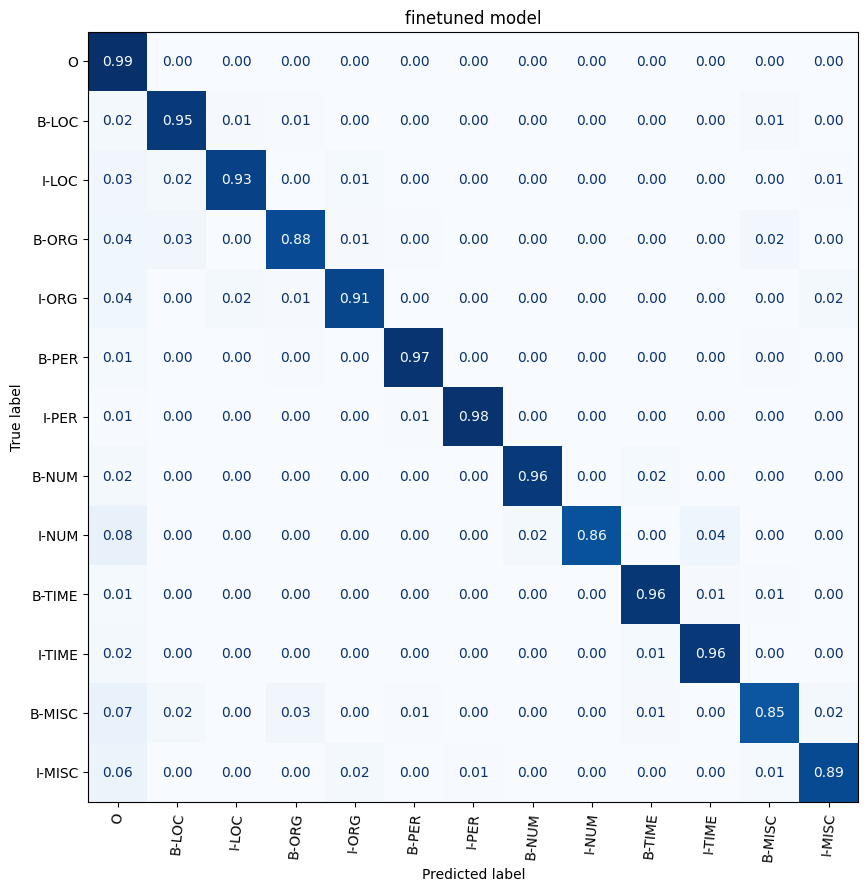

In [25]:
plot_confusion_matrix(prediction_finetuned, labels_finetuned, list(label2id.keys()), "finetuned model")

# Save the model

In [ ]:
trainer.push_to_hub()